# MOLT Solver Tutorial

This notebook is intended to serve as a tool to demonstrate the coding process for the Method-of-Lines-Transpose (MOLT). Additionally, our document is designed to be entirely self-contained with detailed explanations, supplemented with relevant snippets from publications.  

### Import Packages

In [1]:
# Computing
import numpy as np
from numba import jit
from pylab import meshgrid

# Profiling 
import time
import cProfile
import pstats
import io

# Plotting Utilities
import matplotlib.pyplot as plt
from IPython import display
import ipywidgets as widgets
from ipywidgets import interactive
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Time Integration Methods

For time integratration, we use explicit, strong-stability-preseriving Runge-Kutta (SSP-RK) methods to advance the solution from $t^{n}$ to $t^{n+1}$. Let $u^{n} = u(x,t^{n})$ denote the semi-discrete numerical solution at time $t^{n}$. The SSP-RK methods involve convex combinations of forward euler steps, with high-order accuracy being obtained by choosing constants so that the error terms in the Taylor expansion disappear. In practice, we will couple the $k$-stage SSP-RK method with the $k$-th partial sum of the resolvent expansions to maintain consistency. 

The time integration schemes we will be considering for the HJ equation include the forward Euler scheme

\begin{equation}
    u^{n+1} = u^{n} - \Delta t \hat{H} \left( u_{x}^{-}, u_{x}^{+} \right),
\end{equation}

the two-stage SSP-RK scheme

\begin{align}
    u^{(1)} &= u^{n} - \Delta t \hat{H} \left( u_{x}^{n,-}, u_{x}^{n,+} \right) \\
    u^{n+1} &= \frac{1}{2} u^{n} + \frac{1}{2} \left( u^{(1)} - \Delta t \hat{H} \left( u_{x}^{(1),-}, u_{x}^{(1),+} \right) \right)
\end{align}

and the popular three-stage SSP-RK scheme

\begin{align}
    u^{(1)} &= u^{n} - \Delta t \hat{H} \left( u_{x}^{n,-}, u_{x}^{n,+} \right) \\
    u^{(2)} &= \frac{3}{4} u^{n} + \frac{1}{4} \left( u^{(1)} - \Delta t \hat{H} \left( u_{x}^{(1),-}, u_{x}^{(1),+} \right) \right) \\
    u^{n+1} &= \frac{1}{3} u^{n} + \frac{2}{3} \left( u^{(2)} - \Delta t \hat{H} \left( u_{x}^{(2),-}, u_{x}^{(2),+} \right) \right).
\end{align}

In [2]:
def RK1(io, u0, u, dt, rhs):
    # Forward Euler update
    u += dt*rhs
    
    return u

def RK2(io, u0, u, dt, rhs):
    if (io==0):
        u = u0 + dt*rhs
    else:
        u = 0.5*u0 + 0.5*(u + dt*rhs)
    
    return u

def RK3(io, u0, u, dt, rhs):
    if (io==0):
        u = u0 + dt*rhs
    elif (io==1):
        u = 3/4*u0 + 1/4*(u + dt*rhs)
    else:
        u = 1/3*u0 + 2/3*(u + dt*rhs)
        
    return u

## General Functions

These are functions that will be called within each of the methods. We have formatted this section so that the  descriptions are followed by the function used to perform desired manipulations.  

### Setting the Time Step

In 1-D, we select the time step at each interation using

\begin{equation*}
    \Delta t = \text{CFL} \frac{ \Delta x }{ \alpha }, 
\end{equation*}

where $\alpha$ is the maximum wave propogation speed and is given by $ \alpha = \max_{u} \lvert H'(u) \rvert. $
Note: We need to compute $\alpha$ at each time step to get the new value for $\Delta t$. The expression for $ H'(u)$ is determined analytically. We compute the time step size using the function below:

In [3]:
def set_dt(t,t_final,CFL,dx,dy,alphax,alphay):
    '''
    This is the function used to compute the time step size dt.
    
    Input:
    =================================================================
    t: Current time for the integrator.
    t_final: Final time for the integrator.
    CFL: Courant number. 
    dx: Spatial step size.
    alpha: Max wave propagation speed.
    
    Output:
    =================================================================
    dt: Time step size for the next iteration. 
    '''
    dt = CFL / (alphax/dx + alphay/dy)
    
    # End case for the integrator
    if (t + dt > t_final - 1e-10):
        dt = t_final - t
        
    return dt

### Linear Weight Based Quadrature

For many of the HJ problems, using the linear quadrature is sufficient for high order accuracy in space. The solution itself is generally continuous, but we allow the derivative to be discontinuous. In instances where the *solution* is discontinuous, WENO quadrature will be applied to the first term and linear reconstruction will be used on the remaining terms, for problems where $k \geq 2$. Rather than use the nonlinear weights in the quadrature, we allow the nonlinear filters $ \sigma_{i,L} $ and $ \sigma_{i,R} $ to assume a role analogous to the nonlinear weights. This makes the updates cheaper for higher order terms. These nonlinear weights are constructed using data from the WENO quadrature routine. The code for the linear reconstruction is exactly identical to the WENO routines, without needing to construct the nonlinear weights. It is given below.

In [4]:
def integral_linear(v_L,v_R,gamma,dx,bdy_ext):
    '''
    Compute the fifth order linear WENO quadrature approximation 
    to the left convolution integral using a six point global stencil.
    
    Input:
    =================================================================
    v: A 1-D array for the solution at the time step t_n.
    gamma: Parameter specified by MOLT discretization.
    dx: Grid spacing.
    
    Output:
    =================================================================
    J_L: A 1-D array for the reconstructed local integrals to the left.
    '''
    # We need gamma*dx here, so we adjust the value of gamma
    gamma *= dx 
    
    # Get the total number of elements in v
    len_v = v_L.shape[0]
    
    # Create the array to store the local integrals and the filter data
    J_L = np.zeros((len_v))    
    J_R = np.zeros((len_v))
    
    #------------------------------------------------------------------------------------------------------------------
    # Compute the "ENO" weights for the quadrature using the precomputed expressions for the left approximation
    #------------------------------------------------------------------------------------------------------------------
    c_11 = ( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    c_12 = -( 6 - 8*gamma + 3*gamma**2 - ( 6 - 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    c_13 = ( 6 - 10*gamma + 6*gamma**2 - ( 6 - 4*gamma - gamma**2 + 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    c_14 = -( 6 - 12*gamma + 11*gamma**2 - 6*gamma**3 - ( 6 - 6*gamma + 2*gamma**2)*np.exp(-gamma) )/(6*gamma**3)
    
    c_21 = ( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    c_22 = -( 6 - 2*gamma - 2*gamma**2 - ( 6 + 4*gamma - gamma**2 - 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    c_23 = ( 6 - 4*gamma - gamma**2 + 2*gamma**3 - ( 6 + 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    c_24 = -( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    
    c_31 = ( 6 + 6*gamma +2*gamma**2 - ( 6 + 12*gamma + 11*gamma**2 + 6*gamma**3 )*np.exp(-gamma) )/(6*gamma**3)
    c_32 = -( 6 + 4*gamma - gamma**2 - 2*gamma**3 - ( 6 + 10*gamma + 6*gamma**2 )*np.exp(-gamma) )/(2*gamma**3 )
    c_33 = ( 6 + 2*gamma - 2*gamma**2 - ( 6 + 8*gamma + 3*gamma**2 )*np.exp(-gamma) )/(2*gamma**3 )
    c_34 = -( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    
    #------------------------------------------------------------------------------------------------------------------
    # Compute the linear WENO weights
    #------------------------------------------------------------------------------------------------------------------
    d1 = ( 60 - 15*gamma**2 + 2*gamma**4 - ( 60 + 60*gamma + 15*gamma**2 - 5*gamma**3 - 3*gamma**4)*np.exp(-gamma) )
    d1 = d1/(10*(gamma**2)*( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) ) )
    
    d3 = ( 60 - 60*gamma + 15*gamma**2 + 5*gamma**3 - 3*gamma**4 - ( 60 - 15*gamma**2 + 2*gamma**4)*np.exp(-gamma) ) 
    d3 = d3/(10*(gamma**2)*( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) ) )
    
    d2 = 1 - d1 - d3
    
    # Boundary
    bn = 2
    v1 = bdy_ext(v_L, bn)
    v2 = bdy_ext(v_R, bn)

    #------------------------------------------------------------------------------------------------------------------    
    # Compute the local integrals J_{i}^{L} on x_{i-1} to x_{i}, i = 1,...,N+1
    #------------------------------------------------------------------------------------------------------------------

    for i in range(bn,len_v+bn-1):
        
        # Polynomial interpolants on the smaller stencils
        pL_1 = c_11*v1[i-2] + c_12*v1[i-1] + c_13*v1[i  ] + c_14*v1[i+1]
        pL_2 = c_21*v1[i-1] + c_22*v1[i  ] + c_23*v1[i+1] + c_24*v1[i+2]
        pL_3 = c_31*v1[i  ] + c_32*v1[i+1] + c_33*v1[i+2] + c_34*v1[i+3]
        
        # Compute the integral using the nonlinear weights and the local polynomials
        J_L[i-bn+1] = d1*pL_1 + d2*pL_2 + d3*pL_3

        
        # Polynomial interpolants on the smaller stencils
        pR_1 = c_34*v2[i-2] + c_33*v2[i-1] + c_32*v2[i  ] + c_31*v2[i+1]
        pR_2 = c_24*v2[i-1] + c_23*v2[i  ] + c_22*v2[i+1] + c_21*v2[i+2]    
        pR_3 = c_14*v2[i  ] + c_13*v2[i+1] + c_12*v2[i+2] + c_11*v2[i+3]
        
        # Compute the integral using the nonlinear weights and the local polynomials
        J_R[i-bn  ] = d3*pR_1 + d2*pR_2 + d1*pR_3
        
    return J_L, J_R

### Outline of the Fast Convolution Algorithm

In this section, we describe spatial approximations for the operators $\mathcal{D}_{L}$ and $\mathcal{D}_{R}$. We will employ a "trick" to obtain $\mathcal{I}_{0}$ in $\mathcal{D}_{0}$. Recall that

\begin{align}
    \mathcal{D}_L &= \mathcal{I} - \mathcal{L}_{L}^{-1} \\
    \mathcal{D}_R &= \mathcal{I} - \mathcal{L}_{R}^{-1},
\end{align}

where 

\begin{align}
    \mathcal{L}_{L}^{-1} [v,\gamma](x) &= I^{L} [v,\gamma](x) + A_{L} e^{-\gamma (x-a)} \\
    \mathcal{L}_{R}^{-1} [v,\gamma](x) &= I^{R} [v,\gamma](x) + B_{R} e^{-\gamma (b-x)},
\end{align}

and $I^{L} [v,\gamma](x)$ and $I^{R} [v,\gamma](x)$ are convolution integrals. The fast convolution only needs to be applied to $I^{L}$ and $I^{R}$, as the remaining terms can be evaluated directly. Therefore, we focus only on the convolution integrals. 

We proceed by letting $I^{\ast} [v,\gamma](x_i) = I_{i}^{\ast}$ at each grid point, with $\ast$ being $L$ and $R$. Then, we have the following recursive relation

\begin{align}
    I_{i}^{L} &= e^{-\gamma \Delta x_i } I_{i-1}^{L} + J_{i}^{L}, \quad i = 1, \cdots, N \\
    I_{i}^{R} &= e^{-\gamma \Delta x_i } I_{i-1}^{R} + J_{i}^{R}, \quad i = 0, \cdots, N-1, 
\end{align}

where 

\begin{equation}
    J_{i}^{L} = \gamma \int_{x_{i-1}}^{x_i} e^{-\gamma (x_i -y)} v(y) \,dy, \quad J_{i}^{R} = \gamma \int_{x_{i}}^{x_{i+1}} e^{-\gamma (y- x_i)} v(y) \,dy
\end{equation}

are the *local integrals*. A high-order WENO based quadrature is used to discretize each of these local integrals. 

The pseudo-code for the evaluating the integrals is as follows:
1. Set $I_{0}^{L} = 0$ and $I_{N}^{R} = 0$.
2. Compute each of the local integrals $J_{i}^{L}$ and $J_{i}^{R}$ using WENO quadrature. 
3. "Sweep" across the domain from left to right via $I_{i}^{L} = e^{-\gamma \Delta x_i } I_{i-1}^{L} + J_{i}^{L}$. At the end of each iterate, set $i \mapsto i+1$.
4. "Sweep" across the domain from right to left via $I_{i}^{R} = e^{-\gamma \Delta x_i } I_{i-1}^{L} + J_{i}^{L}$. At the end of each iterate, set $i \mapsto i-1$.
5. If the second derivative is needed, compute $I_{0,i} = \frac{1}{2} \left( I_{i}^{L} + I_{i}^{R} \right)$. 

The special feature of this recursive relation is that it allows the convolution algorithm to be evaluated using $\mathcal{O}(N)$ operations, rather than a direct method, which would require $\mathcal{O}(N^2)$ operations. Additionally, each of these local integrals, as well as the sweeps, can be evaluted in parallel. 

In [5]:
@jit
def fast_convolution(J_L,J_R,gamma,dx):
    '''
    This function computes the value of the covolution integral
    at the grid points using a fast-summation algorithm, previously
    descibed.
    
    Input:
    =================================================================
    J_L: A 1-D array for the local integrals on the left.
    J_R: A 1-D array for the local integrals on the right.
    gamma: The MOLT parameter related to the time step.
    dx: Grid spacing.
  
    Output:
    =================================================================
    I_L: A 1-D array for the left convolution integral at the grid points
    I_R: A 1-D array for the right convolution integral at the grid points
    '''
    
    # Initialize the arrays to store the solutions
    N = J_L.shape[0] - 1
    I_L = np.zeros((N+1))
    I_R = np.zeros((N+1))
    
    for i in range(1,N+1):
        
        # Perform the sweeps to the right
        I_L[i] = np.exp( -gamma*dx )*I_L [i-1] + J_L[i]
    
        # Perform the sweeps to the left
        j = N - i
        I_R[j] = np.exp( -gamma*dx )*I_R [j+1] + J_R[j]
    
    return I_L, I_R

### Computing the Inverse Operators

For the case of periodic boundary conditions, we will require

\begin{align*}
    \mathcal{D}_{L}^{k}(a) &= \mathcal{D}_{L}^{k}(b), \quad k = 0,1,2, \cdots \\
    \mathcal{D}_{R}^{k}(a) &= \mathcal{D}_{R}^{k}(b), \quad k = 0,1,2, \cdots \\
    \mathcal{D}_{0}(a) &= \mathcal{D}_{0}(b). 
\end{align*}

We write a total of three routines: one each for dealing with the left and right BCs, and a third for the boundary conditions when the diffusion term is required. We will also be constructing the inverse operators here using the results from the fast convolution routine. These inverse operators are constructed via

\begin{align}
    \mathcal{L}_{L}^{-1} [v,\gamma](x) &= I^{L} [v,\gamma](x) + A_{L} e^{-\gamma (x-a)} \\
    \mathcal{L}_{R}^{-1} [v,\gamma](x) &= I^{R} [v,\gamma](x) + B_{R} e^{-\gamma (b-x)}.
\end{align}

with the constants $A_{L}$ and $B_{R}$ being determined by the periodic BCs. Similarly, for the diffusion term

\begin{equation}
    \mathcal{L}_{0}^{-1} [v,\gamma](x) = \mathcal{I}_{0}[v,\gamma](x) + A_{0} e^{-\gamma(x-a)} + B_{0} e^{-\gamma(b-x)},  
\end{equation}

with constants being determined via periodic boundary conditions.


In [6]:
def inversion(I_L,I_R,x,gamma,A_L,B_R):
    '''
    This function constructs the left going inverse of L using the
    data from the boundary conditions, which we take to be NON periodic.
    
    Input:
    =================================================================
    I_L: A 1-D array for the left convolution integral
    I_R: A 1-D array for the right convolution integral
    x: 1-D array containing the locations of the N+1 grid points.
    gamma: The MOLT parameter related to the time step.
    A_L:The last entry of I_L is the integral over [a,b]
    B_R:The last entry of I_R is the integral over [a,b]
     
    Output:
    =================================================================
    I_L: A 1-D array for the inverse of the operator L_L
    I_R: A 1-D array for the inverse of the operator L_R
    '''    
    # Now construct L_Linv through summation
    for i in range(x.size):
        
        I_L[i] += A_L*np.exp(-gamma*( x[i] - x[0] )) 
        I_R[i] += B_R*np.exp(-gamma*( x[-1] - x[i] )) 
        
    return I_L, I_R


In [7]:
def get_boundary(v1,v2,gamma,dx):
    '''
    Left = periodic or Dirichlet=periodic case
    Right =periodic or outflow
    Taylor expansion on the variable t at the left and right boundaries
    
    Input:
    =================================================================
    v1/v2: 1-D array containing the left and right boundary points.
    dx: Grid spacing.
    
    Output:
    =================================================================
    A/B: left/right boundary approximation for the updated solution at the next time step
    '''

    c4 = np.array( [-2, 9, -18, 11] ) 
    c4 = c4/6/dx

    A = v1[-1] - (sum(c4*v1)) /gamma
    B = v2[-1] + (sum(c4*v2)) /gamma
    
    
    return A, B

## Numerical Examples

We examine the performance of the described schemes on several test problems. Each section of code for computing the solution to an example is intended to be a different instance. 

### 1-D Example: Problem 1

We demonstrate the method on the 1-D Burger's equation:

\begin{equation*}
     u_t + \frac{1}{2} \left( u_x + 1 \right)^{2} = 0, \quad -1 \leq x \leq 1, \quad t \in [0,1]
\end{equation*}

subject to the initial condition (IC)

\begin{equation*}
     u(x,0) = -\cos (\pi x).
\end{equation*}

This implementation also uses periodic boundary conditions (BCs) so that

\begin{equation*}
    u(-1,t) = u(1,t), \quad u_x (-1,t) = u_x (1,t)
\end{equation*}
hold.

### First Order Scheme

For the first order scheme, we use only the first term in the partial sums for the first order derivatives:

\begin{align}
    u_{x}^{-}(x) &\approx \gamma \mathcal{D}_{L} [u,\gamma](x) \\
    u_{x}^{+}(x) &\approx -\gamma \mathcal{D}_{R} [u,\gamma](x). 
\end{align}


In [8]:
def molt(u_L,u_R,x,gamma,dx,bdy_ext):
    
    # Get the local integrals using the WENO quadrature 
    J_L, J_R = integral_linear(u_L,u_R,gamma,dx,bdy_ext)
    
    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,gamma,dx)
    
    # Use the left/right BC to get boundary terms
    A, B = get_boundary(u_L[-4:],u_R[-4:],gamma,dx)
    
    # Get L_Linv/L_Rinv
    L_Linv, L_Rinv = inversion(I_L,I_R,x,gamma,A,B)
    
    return L_Linv, L_Rinv


In [9]:
def MOLT_HJ_1(x,y,U,H,D1Hx,D1Hy,bdy_ext,dx,dy,dt,CFL,alphax,alphay,beta):
    '''
    Function for the first order MOLT-HJ scheme. It integrates the
    solution over one time step via the forward Euler scheme.  
    
    Input:
    =================================================================
    u: A 1-D array for the solution at the time step t_n.
    x: 1-D array containing the locations of the N+1 grid points.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    alpha: Max wave propogation speed.
    beta: Stability parameter for the method. 
    
    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    alpha: Maximum wave propogation speed
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1

    rhs = np.zeros((N+1,N+1))
    u_xm = np.zeros((N+1,N+1))
    u_ym = np.zeros((N+1,N+1))
    u_xp = np.zeros((N+1,N+1))
    u_yp = np.zeros((N+1,N+1))
    
    # Compute the specified MOLT parameter 
    gamma = beta/(alphax*dt)
    
    for j in range(N+1):
        u = U[:, j]
        
        # MOLT process
        L_Linv, L_Rinv = molt(u,u,x,gamma,dx,bdy_ext)
    
        # Construct the left/right derivative with the definition of D_L/D_R
        u_xm[:,j] =  gamma*( u - L_Linv ).transpose()
        u_xp[:,j] = -gamma*( u - L_Rinv ).transpose()
        
    gamma = beta/(alphay*dt)    
    for i in range(N+1):
        
        u = U[i,:]
        
        # MOLT process
        L_Linv, L_Rinv = molt(u,u,y,gamma,dy,bdy_ext)
    
        # Construct the left/right derivative with the definition of D_L/D_R
        u_ym[i][:] =  gamma*( u - L_Linv )
        u_yp[i][:] = -gamma*( u - L_Rinv )
        

    # Build the RHS
    # Max wave speed from the current solution used in the LxF splitting
    alphax = np.max(np.abs(D1Hx(u_xp, u_yp)))
    alphay = np.max(np.abs(D1Hy(u_xm, u_ym)))
    
    # Compute the numerical H corresponding to the RHS with the LxF splitting
    rhs = - H( 0.5*(u_xm + u_xp), 0.5*(u_ym + u_yp) ) \
          + alphax*0.5*(u_xp - u_xm) + alphay*0.5*(u_yp - u_ym)
    
    return rhs, alphax, alphay


### Second Order Scheme

The second order scheme is identical to the first with an extra term in the partial sum. In addition, we modify the original schemes using nonlinear filters $\sigma_{L}$ and $\sigma_{R}$ to tame highly oscillatory contributions from $\mathcal{D}_{L}^{2}$ and $\mathcal{D}_{R}^{2}$. The resulting scheme is

\begin{align}
    u_{x}^{-}(x) &\approx \gamma \mathcal{D}_{L} [u,\gamma](x) + \gamma \sigma_{L}\mathcal{D}_{L}^{2} [u,\gamma](x) \\
    u_{x}^{+}(x) &\approx -\gamma \mathcal{D}_{R} [u,\gamma](x) - \gamma \sigma_{R} \mathcal{D}_{R}^{2} [u,\gamma](x). 
\end{align}

In [10]:
def MOLT_HJ_2(x,y,U,H,D1Hx,D1Hy,bdy_ext,dx,dy,dt,CFL,alphax,alphay,beta):
    '''
    Function for the first order MOLT-HJ scheme. It integrates the
    solution over one time step via the forward Euler scheme.  
    
    Input:
    =================================================================
    u: A 1-D array for the solution at the time step t_n.
    x: 1-D array containing the locations of the N+1 grid points.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    alpha: Max wave propogation speed.
    beta: Stability parameter for the method. 
    
    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    alpha: Maximum wave propogation speed
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1

    rhs = np.zeros((N+1,N+1))
    u_xm = np.zeros((N+1,N+1))
    u_ym = np.zeros((N+1,N+1))
    u_xp = np.zeros((N+1,N+1))
    u_yp = np.zeros((N+1,N+1))
    
    gamma = beta/(alphax*dt)
    for j in range(N+1):
        u = U[:, j]
        u = u.transpose()
        #------------------------------------------------------------------
        # Build the first order term D^1 
        #------------------------------------------------------------------
        # MOLT process
        L_Linv, L_Rinv = molt(u,u,x,gamma,dx,bdy_ext)
        
        D_L = u - L_Linv
        D_R = u - L_Rinv
        
        u_xm[:,j] =  gamma*( D_L ).transpose()
        u_xp[:,j] = -gamma*( D_R ).transpose()
        
        #------------------------------------------------------------------
        # Build the second order term D^2 using D_L and D_R as input 
        #------------------------------------------------------------------
        # MOLT process
        L_Linv, L_Rinv = molt(D_L,D_R,x,gamma,dx,bdy_ext)
        
        D2_L = D_L - L_Linv
        D2_R = D_R - L_Rinv
    
        u_xm[:,j] +=  gamma*( D2_L ).transpose()#*sigma_L
        u_xp[:,j] += -gamma*( D2_R ).transpose()#*sigma_R
        
    
    gamma = beta/(alphay*dt)    
    for i in range(N+1):
        
        u = U[i,:]
        
        #------------------------------------------------------------------
        # Build the first order term D^1 
        #------------------------------------------------------------------
        # MOLT process
        L_Linv, L_Rinv = molt(u,u,y,gamma,dy,bdy_ext)
           
        D_L = u - L_Linv
        D_R = u - L_Rinv
        
        u_ym[i][:] =  gamma*( D_L )
        u_yp[i][:] = -gamma*( D_R )
        
        #------------------------------------------------------------------
        # Build the second order term D^2 using D_L and D_R as input 
        #------------------------------------------------------------------
        # MOLT process
        L_Linv, L_Rinv = molt(D_L,D_R,y,gamma,dy,bdy_ext)
        
        D2_L = D_L - L_Linv
        D2_R = D_R - L_Rinv
    
        u_ym[i][:] +=  gamma*( D2_L )#*sigma_L
        u_yp[i][:] += -gamma*( D2_R )#*sigma_R

        
    # Build the RHS
    # Max wave speed from the current solution used in the LxF splitting
    alphax = np.max(np.abs(D1Hx(u_xp, u_yp)))
    alphay = np.max(np.abs(D1Hy(u_xm, u_ym)))
    
    # Compute the numerical H corresponding to the RHS with the LxF splitting
    rhs = - H( 0.5*(u_xm + u_xp), 0.5*(u_ym + u_yp) ) \
          + alphax*0.5*(u_xp - u_xm) + alphay*0.5*(u_yp - u_ym)

    return rhs, alphax, alphay


### Third Order Scheme

The case for the third order scheme is similar to the above for the second order case. We modify the original scheme to give only three constributions from the partial sum. These modifications involve applications of the nonlinear filters $\sigma_{L}$ and $\sigma_{R}$ to tame highly oscillatory contributions from $\mathcal{D}_{L}^{k}$ and $\mathcal{D}_{R}^{k}$, where $k \geq 2$. The resulting scheme is

\begin{align}
    u_{x}^{-}(x) &\approx \gamma \mathcal{D}_{L} [u,\gamma](x) + \gamma \sigma_{L} \mathcal{D}_{L}^{2} [u,\gamma](x) + \gamma \sigma_{L}^{2} \mathcal{D}_{L}^{3} [u,\gamma](x) \\
    u_{x}^{+}(x) &\approx -\gamma \mathcal{D}_{R} [u,\gamma](x) - \gamma \sigma_{R} \mathcal{D}_{R}^{2} [u,\gamma](x) - \gamma \sigma_{R}^{2} \mathcal{D}_{R}^{3} [u,\gamma](x). 
\end{align}

Note that we no longer have the diffusion terms involving $\mathcal{D}_{0}$, which were previously required to maintain stability.

In [11]:
@jit 
def MOLT_HJ_3(x,y,U,H,D1Hx,D1Hy,bdy_ext,dx,dy,dt,CFL,alphax,alphay,beta):
    '''
    Function for the first order MOLT-HJ scheme. It integrates the
    solution over one time step via the forward Euler scheme.  
    
    Input:
    =================================================================
    u: A 1-D array for the solution at the time step t_n.
    x: 1-D array containing the locations of the N+1 grid points.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    alpha: Max wave propogation speed.
    beta: Stability parameter for the method. 
    
    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    alpha: Maximum wave propogation speed
    '''
    # Initialize an array to store the RHS
    N = x.shape[0] -1

    rhs = np.zeros((N+1,N+1))
    U_xm = np.zeros((N+1,N+1))
    U_ym = np.zeros((N+1,N+1))
    U_xp = np.zeros((N+1,N+1))
    U_yp = np.zeros((N+1,N+1))
    c2 = np.array( [-1, 4, -5, 2] ) #/(dx**2)
    c3 = np.array( [1, -3, 3, -1] ) #/(dx**3)
    
    gamma = beta/(alphax*dt)
    for j in range(N+1):
        u = U[:, j]
        
        #------------------------------------------------------------------
        # Build the first order term D^1 
        #------------------------------------------------------------------
        # MOLT process
        L_Linv, L_Rinv = molt(u,u,x,gamma,dx,bdy_ext)
        
        D_L = u - L_Linv
        D_R = u - L_Rinv
        
        u_xm =  gamma*( D_L )
        u_xp = -gamma*( D_R )
        
        #------------------------------------------------------------------
        # Build the second order term D^2 using D_L and D_R as input 
        #------------------------------------------------------------------
        dxx_a =  1/gamma**2 * (sum(c2*u[-4:])) /(dx**2)  
        dxx_b =  1/gamma**2 * (sum(c2*u[-4:])) /(dx**2)
        D_L, D_R = inversion(D_L,D_R,x,gamma,-dxx_a,-dxx_b) #D_L - dxx_a
    
        # MOLT process
        L_Linv, L_Rinv = molt(D_L,D_R,x,gamma,dx,bdy_ext)
        
        D2_L = D_L - L_Linv
        D2_R = D_R - L_Rinv
    
        u_xm +=  gamma*( D2_L )
        u_xp += -gamma*( D2_R )
        
        #------------------------------------------------------------------
        # Build the third order terms using D2_L and D2_R as input 
        #------------------------------------------------------------------
        dxxx_a =  1/gamma**3 * (sum(c3*u[-4:])) /(dx**3)  
        dxxx_b =  1/gamma**3 * (sum(c3*u[-4:])) /(dx**3)
        D2_L, D2_R = inversion(D2_L,D2_R,x,gamma,-dxxx_a,dxxx_b)        
        
        # MOLT process
        L_Linv, L_Rinv = molt(D2_L,D2_R,x,gamma,dx,bdy_ext)
            
        D3_L = D2_L - L_Linv
        D3_R = D2_R - L_Rinv
        
        u_xm +=  gamma*( D3_L )
        u_xp += -gamma*( D3_R )
                
        ###
        u_xm, u_xp =  inversion(u_xm,u_xp,x,gamma,-gamma*dxx_a,-gamma*dxx_b)
     
        #------------------------------------------------------------------
        # Stability term 1
        #------------------------------------------------------------------
        # Left
        L_LLinv, L_LRinv = molt(D2_L,D2_L,x,gamma,dx,bdy_ext)
        L_L0 = 0.5*(L_LLinv + L_LRinv)
        # Right
        L_RLinv, L_RRinv = molt(D2_R,D2_R,x,gamma,dx,bdy_ext)
        L_R0 = 0.5*(L_RLinv + L_RRinv)
        
        u_xm += -gamma*( D2_L - L_L0 )
        u_xp +=  gamma*( D2_R - L_R0 )
        
        ###   
        U_xm[:,j] = u_xm.transpose()
        U_xp[:,j] = u_xp.transpose()
        
    gamma = beta/(alphay*dt)    
    for i in range(N+1):
        
        u = U[i,:]
        
        #------------------------------------------------------------------
        # Build the first order term D^1 
        #------------------------------------------------------------------
        # MOLT process
        L_Linv, L_Rinv = molt(u,u,y,gamma,dy,bdy_ext)
           
        D_L = u - L_Linv
        D_R = u - L_Rinv
        
        u_ym =  gamma*( D_L )
        u_yp = -gamma*( D_R )
        
        #------------------------------------------------------------------
        # Build the second order term D^2 using D_L and D_R as input 
        #------------------------------------------------------------------
        dyy_a =  1/gamma**2 * (sum(c2*u[-4:])) /(dy**2)  
        dyy_b =  1/gamma**2 * (sum(c2*u[-4:])) /(dy**2)
        D_L, D_R = inversion(D_L,D_R,y,gamma,-dyy_a,-dyy_b) #D_L - dxx_a
    
        # MOLT process
        L_Linv, L_Rinv = molt(D_L,D_R,y,gamma,dy,bdy_ext)
        
        D2_L = D_L - L_Linv
        D2_R = D_R - L_Rinv
    
        u_ym +=  gamma*( D2_L )#*sigma_L
        u_yp += -gamma*( D2_R )#*sigma_R

        #------------------------------------------------------------------
        # Build the third order terms using D2_L and D2_R as input 
        #------------------------------------------------------------------
        dyyy_a =  1/gamma**3 * (sum(c3*u[-4:])) /(dy**3) 
        dyyy_b =  1/gamma**3 * (sum(c3*u[-4:])) /(dy**3)
        D2_L, D2_R = inversion(D2_L,D2_R,y,gamma,-dyyy_a,dyyy_b) 
        
        # MOLT process        
        L_Linv, L_Rinv = molt(D2_L,D2_R,y,gamma,dy,bdy_ext)
        
        D3_L = D2_L - L_Linv
        D3_R = D2_R - L_Rinv
        
        u_ym +=  gamma*( D3_L )#*(sigma_L**2)
        u_yp += -gamma*( D3_R )#*(sigma_R**2)
                
        ###
        u_ym, u_yp =  inversion(u_ym,u_yp,y,gamma,-gamma*dyy_a,-gamma*dyy_b)
    
        #------------------------------------------------------------------
        # Stability term 1
        #------------------------------------------------------------------
        # Left
        L_LLinv, L_LRinv = molt(D2_L,D2_L,y,gamma,dy,bdy_ext)
        L_L0 = 0.5*(L_LLinv + L_LRinv)
        # Right
        L_RLinv, L_RRinv = molt(D2_R,D2_R,y,gamma,dy,bdy_ext)
        L_R0 = 0.5*(L_RLinv + L_RRinv)   
        
        u_ym += -gamma*( D2_L - L_L0 ) #*(sigma_L**2)
        u_yp +=  gamma*( D2_R - L_R0 ) #*(sigma_R**2)
        
        ###    
        U_ym[i][:] = u_ym
        U_yp[i][:] = u_yp

    # Build the RHS
    # Max wave speed from the current solution used in the LxF splitting
    alphax = np.max(np.abs(D1Hx(U_xp, U_yp)))
    alphay = np.max(np.abs(D1Hy(U_xm, U_ym)))
    
    # Compute the numerical H corresponding to the RHS with the LxF splitting
    rhs = - H( 0.5*(U_xm + U_xp), 0.5*(U_ym + U_yp) ) \
      + alphax*0.5*(U_xp - U_xm) + alphay*0.5*(U_yp - U_ym)

    return rhs, alphax, alphay


### Set the Initial Condition

In [12]:
def Problem0():
    '''
    Example. Advection equation for smooth function
    '''
    DomX = [-2, 2]
    DomY = [-2, 2]
    
    def H(ux, uy):
        H = ux + uy
        return H
    
    def D1Hx(ux, uy):
        D1H = (1)
        return D1H

    def D1Hy(ux, uy):
        D1H = (1)
        return D1H
    
    def u_naut(x, y):
        u = - np.cos( np.pi*(x + y)/2 )
        return u
    
    def alpha0(x, y):
        # dH with du_naut
        alpha = 1
        return alpha
    
    # Time interval
    t_final = 0.1
    
    # Boundary Conditions
    def bdy_ext(*args):
        bdy_ext = bdy_per(args[0],args[1])
#         bdy_ext = bdy_dir(args[0],args[1])

        return bdy_ext
    
    def exact(x, y, t):
        u = - np.cos( np.pi*((x + y)/2 - t) )
        return u

    return DomX, DomY, H, D1Hx, D1Hy, u_naut, alpha0, t_final, bdy_ext, exact

In [13]:
def Problem1():
    '''
    Example 4.2. Burgers' equation
    '''
    DomX = [-2, 2]
    DomY = [-2, 2]
    
    def H(ux, uy):
        H = 0.5*(ux + uy + 1)**2
        return H
    
    def D1Hx(ux, uy):
        D1H = (ux + uy + 1)
        return D1H
    
    def D1Hy(ux, uy):
        D1H = (ux + uy + 1)
        return D1H
    
    def u_naut(x, y):
        u = - np.cos( np.pi*(x + y)/2 )
        return u
    
    def alpha0(x, y):
        # dH with du_naut
        alpha = np.amax( np.abs(1 + np.pi*np.sin( np.pi*(x + y)/2 )) )
        return alpha
    
    t_final = 0.5/(np.pi)**2 
    
    # Boundary Conditions
    def bdy_ext(*args):
        bdy_ext = bdy_per(args[0],args[1])
#         bdy_ext = bdy_dir(args[0],args[1])

        return bdy_ext
    

    
    def exact(X,Y,t):
        N = X.shape[0]
        exact = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                exact[i,j] = exact1d((x[i]+y[j])/2,t)
        
        return exact
    
    def exact1d(x,t):
        y=fn1(x,t)
        x0=x-t*y
        exact = -np.cos(np.pi*x0) + t*((y-1)*y - 0.5*y**2)
        return exact
    
    def fn1(x,t):
        a=1
        xe=x-a*t
        te=np.pi*t
        ye=fn2(xe,te)
        fn1= 1 + np.pi*ye
        return fn1
    
    def fn2(x,t):
        
        x0=x
        if (x0>1):
            x0=x0-2*int((x0+1)*0.5)
        if (x0<-1):
            x0=x0+2*int((1-x0)*0.5)
        xa=np.abs(x0)
        uu=np.zeros(200)
        ue = 0
        for i in range(200):
            xx=(i)/200
            uu[i]=np.sin(np.pi*xx)
            xt=xx+t*uu[i]
            if (xa<xt):
                ue=uu[i]
                break
        un=ue+1
        u0=ue
        while (np.abs(un-u0)>1e-14):
            xn=xa-ue*t
            un=ue - (ue - np.sin(np.pi*xn))/(1 + np.pi*np.cos(np.pi*xn)*t)
            u0=ue
            ue=un
        ye=np.sign(1)*np.sign(x0)*un
#         print('ye=',ye)
        if (np.abs(xa-1)<1e-12):
            ye=0
        if (np.abs(t)<1e-12):
            ye=np.sin(np.pi*x0)
#         y[k]=ye
        y=ye
    
        return y
    
    
    return DomX, DomY, H, D1Hx, D1Hy, u_naut, alpha0, t_final, bdy_ext, exact

In [14]:
# Periodic boundary points
def bdy_per(v, bn):
    len_v = v.shape[0]
    v2 = np.zeros(len_v + 2*bn)
    
    v2[0:bn] = v[-bn-1:-1]
    v2[bn:len_v+bn] = v
    v2[len_v+bn:len_v+2*bn] = v[1:bn+1]
    
    return v2 

# Boundary points extrapolation
def bdy_dir(v,bn):
    # Here, bn is always 2
    len_v = v.shape[0]
    v2 = np.zeros(len_v + 2*bn)
    
    v2[0   ] = 15*v[0]- 40*v[1] + 45*v[2] -24*v[3] + 5*v[4]
    v2[bn-1] =  5*v[0]- 10*v[1] + 10*v[2] - 5*v[3] +    v[4]
    v2[bn:len_v+bn] = v
    v2[len_v+  bn  ] =  5*v[-1] - 10*v[-2] + 10*v[-3] -  5*v[-4] +   v[-5]
    v2[len_v+2*bn-1] = 15*v[-1] - 40*v[-2] + 45*v[-3] - 24*v[-4] + 5*v[-5]
    
    return v2

### Main

Total time (s): 17.27866840362549


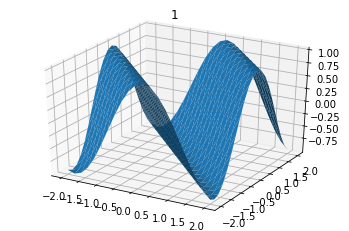

Total time (s): 3.982983112335205


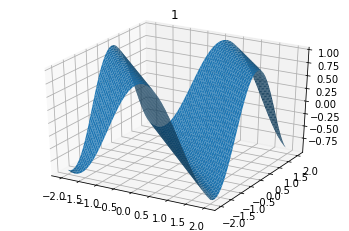

Total time (s): 26.70108914375305


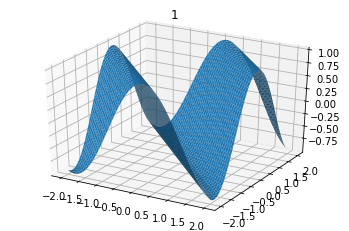

Total time (s): 223.59051275253296


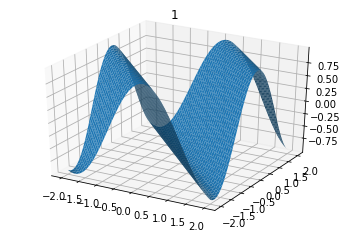

Total time (s): 1860.0485026836395


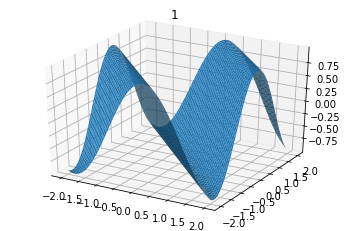


### k = 3 , Linear (Periodic) : CFL = 0.5
Nx=Ny : <Linf Err> & (Ord) || <L1 Err> & (Ord)
  20  :   8.16e-04 &   --  || 1.34e-04 &   -- 
  40  :   7.92e-05 & 3.366 || 1.13e-05 & 3.569
  80  :   9.83e-06 & 3.010 || 1.10e-06 & 3.355
 160  :   1.69e-06 & 2.538 || 1.25e-07 & 3.143
 320  :   2.29e-07 & 2.883 || 1.51e-08 & 3.049


In [15]:

DomX, DomY, H, D1Hx, D1Hy, u_naut, alpha0, t_final, bdy_ext, exact = Problem0()

# Scheme
ik = 3
if (ik==1):
    MOLT_HJ = MOLT_HJ_1
    RK = RK1
    beta = 1

elif (ik==2):
    MOLT_HJ = MOLT_HJ_2
    RK = RK2
    beta = 0.5
    
elif (ik==3):
    MOLT_HJ = MOLT_HJ_3
    RK = RK3
    beta = 0.6

# CFL number
CFL = 0.5

# The number of refinement steps
M = 5
err1=np.zeros(M)
err2=np.zeros(M) 

# Time interval
t_init = 0


for k in range(M):

    # Number of grid points and boundary extension number
    Nx = 20*2**(k)
    Ny = 20*2**(k)

    # Set dx
    dx = (DomX[1]-DomX[0])/Nx
    dy = (DomY[1]-DomY[0])/Ny
    
    # Generate the grid points with the ends included
    x = np.linspace(DomX[0], DomX[1], Nx+1, endpoint=True)
    y = np.linspace(DomY[0], DomY[1], Ny+1, endpoint=True)
    X, Y = meshgrid(x, y)
    
    start_time = time.time()
    
    # Set the IC
    u= u_naut(X, Y)
    
    # Compute alpha for the IC
    alphax=alpha0(X, Y)
    alphay=alpha0(X, Y)
    
    # Intialize t
    t = t_init
    

    while t < t_final:
        dt = set_dt(t,t_final,CFL,dx,dy,alphax,alphay)
        
        u0 = u
        for io in range(0,ik):
            rhs, alphax, alphay = MOLT_HJ(x,y,u,H,D1Hx,D1Hy,bdy_ext,dx,dy,dt,CFL,alphax,alphay,beta)
            u = RK(io, u0, u, dt, rhs)
        
        t += dt    
            
    U1=u
    
    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )

    Us = exact(X,Y,t_final) ############## need to construct an exact function
    
    err1[k] = np.max(np.abs(Us-U1))
    err2[k] = np.sum(np.abs(Us-U1)/Nx/Ny)
    
    ax=plt.axes(projection='3d')
    ax.plot_surface(X,Y,U1)
    plt.title('1')
    plt.show()
#     ax=plt.axes(projection='3d')
#     ax.plot_surface(X,Y,Us)
#     plt.title('exact')
#     plt.show()

ord1=(np.log(err1[1:None]/err1[0:-1]))/(np.log(1/2))
ord2=(np.log(err2[1:None]/err2[0:-1]))/(np.log(1/2))

print('\n### k =', ik, ', Linear (Periodic) : CFL =',CFL)
print("Nx=Ny : <Linf Err> & (Ord) || <L1 Err> & (Ord)")
print("{:4d}".format(20),' :  ',"{:.2e}".format(err1[0]), '&   -- ','||',"{:.2e}".format(err2[0]), '&   -- ')
for k in range(M-1):
    print("{:4d}".format(20*2**(k+1)),' :  ',"{:.2e}".format(err1[k+1]),'&', "{:.3f}".format(ord1[k]),'||',"{:.2e}".format(err2[k+1]),'&', "{:.3f}".format(ord2[k]))


In [16]:

DomX, DomY, H, D1Hx, D1Hy, u_naut, alpha0, t_final, bdy_ext, exact = Problem0()

# Scheme
ik = 3
if (ik==1):
    MOLT_HJ = MOLT_HJ_1
    RK = RK1
    beta = 1

elif (ik==2):
    MOLT_HJ = MOLT_HJ_2
    RK = RK2
    beta = 0.5
    
elif (ik==3):
    MOLT_HJ = MOLT_HJ_3
    RK = RK3
    beta = 0.6

# CFL number
CFL = 1

# The number of refinement steps
M = 5
err1=np.zeros(M)
err2=np.zeros(M) 

# Time interval
t_init = 0


for k in range(M):

    # Number of grid points and boundary extension number
    Nx = 20*2**(k)
    Ny = 20*2**(k)

    # Set dx
    dx = (DomX[1]-DomX[0])/Nx
    dy = (DomY[1]-DomY[0])/Ny
    
    # Generate the grid points with the ends included
    x = np.linspace(DomX[0], DomX[1], Nx+1, endpoint=True)
    y = np.linspace(DomY[0], DomY[1], Ny+1, endpoint=True)
    X, Y = meshgrid(x, y)
    
    start_time = time.time()
    
    # Set the IC
    u= u_naut(X, Y)
    
    # Compute alpha for the IC
    alphax=alpha0(X, Y)
    alphay=alpha0(X, Y)
    
    # Intialize t
    t = t_init
    

    while t < t_final:
        dt = set_dt(t,t_final,CFL,dx,dy,alphax,alphay)
        
        u0 = u
        for io in range(0,ik):
            rhs, alphax, alphay = MOLT_HJ(x,y,u,H,D1Hx,D1Hy,bdy_ext,dx,dy,dt,CFL,alphax,alphay,beta)
            u = RK(io, u0, u, dt, rhs)
        
        t += dt    
            
    U1=u
    
    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )

    Us = exact(X,Y,t_final) ############## need to construct an exact function
    
    err1[k] = np.max(np.abs(Us-U1))
    err2[k] = np.sum(np.abs(Us-U1)/Nx/Ny)
    
#     ax=plt.axes(projection='3d')
#     ax.plot_surface(X,Y,U1)
#     plt.title('1')
#     plt.show()
#     ax=plt.axes(projection='3d')
#     ax.plot_surface(X,Y,Us)
#     plt.title('exact')
#     plt.show()

ord1=(np.log(err1[1:None]/err1[0:-1]))/(np.log(1/2))
ord2=(np.log(err2[1:None]/err2[0:-1]))/(np.log(1/2))

print('\n### k =', ik, ', Linear (Periodic) : CFL =',CFL)
print("Nx=Ny : <Linf Err> & (Ord) || <L1 Err> & (Ord)")
print("{:4d}".format(20),' :  ',"{:.2e}".format(err1[0]), '&   -- ','||',"{:.2e}".format(err2[0]), '&   -- ')
for k in range(M-1):
    print("{:4d}".format(20*2**(k+1)),' :  ',"{:.2e}".format(err1[k+1]),'&', "{:.3f}".format(ord1[k]),'||',"{:.2e}".format(err2[k+1]),'&', "{:.3f}".format(ord2[k]))


Total time (s): 15.44235348701477
Total time (s): 2.0329627990722656
Total time (s): 15.346670866012573
Total time (s): 115.31825304031372
Total time (s): 924.4187309741974

### k = 3 , Linear (Periodic) : CFL = 1
Nx=Ny : <Linf Err> & (Ord) || <L1 Err> & (Ord)
  20  :   6.54e-03 &   --  || 1.44e-03 &   -- 
  40  :   7.18e-04 & 3.187 || 1.19e-04 & 3.593
  80  :   8.95e-05 & 3.004 || 1.05e-05 & 3.502
 160  :   1.11e-05 & 3.014 || 1.08e-06 & 3.277
 320  :   1.88e-06 & 2.562 || 1.26e-07 & 3.103


In [17]:

DomX, DomY, H, D1Hx, D1Hy, u_naut, alpha0, t_final, bdy_ext, exact = Problem0()

# Scheme
ik = 3
if (ik==1):
    MOLT_HJ = MOLT_HJ_1
    RK = RK1
    beta = 1

elif (ik==2):
    MOLT_HJ = MOLT_HJ_2
    RK = RK2
    beta = 0.5
    
elif (ik==3):
    MOLT_HJ = MOLT_HJ_3
    RK = RK3
    beta = 0.6

# CFL number
CFL = 2

# The number of refinement steps
M = 5
err1=np.zeros(M)
err2=np.zeros(M) 

# Time interval
t_init = 0


for k in range(M):

    # Number of grid points and boundary extension number
    Nx = 20*2**(k)
    Ny = 20*2**(k)

    # Set dx
    dx = (DomX[1]-DomX[0])/Nx
    dy = (DomY[1]-DomY[0])/Ny
    
    # Generate the grid points with the ends included
    x = np.linspace(DomX[0], DomX[1], Nx+1, endpoint=True)
    y = np.linspace(DomY[0], DomY[1], Ny+1, endpoint=True)
    X, Y = meshgrid(x, y)
    
    start_time = time.time()
    
    # Set the IC
    u= u_naut(X, Y)
    
    # Compute alpha for the IC
    alphax=alpha0(X, Y)
    alphay=alpha0(X, Y)
    
    # Intialize t
    t = t_init
    

    while t < t_final:
        dt = set_dt(t,t_final,CFL,dx,dy,alphax,alphay)
        
        u0 = u
        for io in range(0,ik):
            rhs, alphax, alphay = MOLT_HJ(x,y,u,H,D1Hx,D1Hy,bdy_ext,dx,dy,dt,CFL,alphax,alphay,beta)
            u = RK(io, u0, u, dt, rhs)
        
        t += dt    
            
    U1=u
    
    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )

    Us = exact(X,Y,t_final) ############## need to construct an exact function
    
    err1[k] = np.max(np.abs(Us-U1))
    err2[k] = np.sum(np.abs(Us-U1)/Nx/Ny)
    
#     ax=plt.axes(projection='3d')
#     ax.plot_surface(X,Y,U1)
#     plt.title('1')
#     plt.show()
#     ax=plt.axes(projection='3d')
#     ax.plot_surface(X,Y,Us)
#     plt.title('exact')
#     plt.show()

ord1=(np.log(err1[1:None]/err1[0:-1]))/(np.log(1/2))
ord2=(np.log(err2[1:None]/err2[0:-1]))/(np.log(1/2))

print('\n### k =', ik, ', Linear (Periodic) : CFL =',CFL)
print("Nx=Ny : <Linf Err> & (Ord) || <L1 Err> & (Ord)")
print("{:4d}".format(20),' :  ',"{:.2e}".format(err1[0]), '&   -- ','||',"{:.2e}".format(err2[0]), '&   -- ')
for k in range(M-1):
    print("{:4d}".format(20*2**(k+1)),' :  ',"{:.2e}".format(err1[k+1]),'&', "{:.3f}".format(ord1[k]),'||',"{:.2e}".format(err2[k+1]),'&', "{:.3f}".format(ord2[k]))


Total time (s): 0.36003732681274414
Total time (s): 1.063157081604004
Total time (s): 7.437110662460327
Total time (s): 58.027827501297
Total time (s): 454.03605794906616

### k = 3 , Linear (Periodic) : CFL = 2
Nx=Ny : <Linf Err> & (Ord) || <L1 Err> & (Ord)
  20  :   6.54e-03 &   --  || 1.44e-03 &   -- 
  40  :   5.57e-03 & 0.232 || 1.32e-03 & 0.127
  80  :   7.26e-04 & 2.939 || 1.10e-04 & 3.585
 160  :   8.63e-05 & 3.073 || 9.78e-06 & 3.488
 320  :   1.03e-05 & 3.064 || 1.02e-06 & 3.266
